In [50]:
import csv

#所有气象站最高气温数据
stations_maxtemp = {}
#读取csv文件
with open('Summary of Weather.csv') as f:
    reader = csv.DictReader(f)
    for item in reader:
        sta = item['STA']
        stations_maxtemp[sta] = stations_maxtemp.get(sta, [])
        stations_maxtemp[sta].append(float(item['MaxTemp']))

#气象站总量
print(len(stations_maxtemp))

        

159


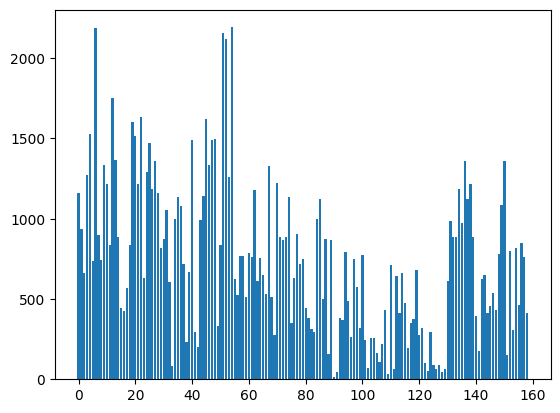

In [51]:
#检测连续记录气温的长度
import matplotlib.pyplot as plt

temp_length = [len(temp) for temp in stations_maxtemp.values()]
plt.bar(range(len(temp_length)), temp_length)
plt.show()

In [52]:
#过滤掉过短的样本
max_temp = [temps for temps in stations_maxtemp.values() if len(temps) > 20]

len(max_temp)

158

In [ ]:
#观察样本温度异常值
plt.figure(figsize=(20, 200))

for i, temps in enumerate(range(79)):
    plt.subplot(79, 2, i*2 + 1)
    temps = max_temp[i]
    plt.plot(range(len(temps)), temps)
    temps = max_temp[i+1]
    plt.plot(range(len(temps)), temps)
plt.show()


In [54]:
#过滤掉极寒异常值
filted_maxtemp = [[temp for temp in temps if temp > -17] for temps in max_temp]

In [ ]:
plt.figure(figsize=(20, 200))

for i, temps in enumerate(range(79)):
    plt.subplot(79, 2, i*2 + 1)
    temps = filted_maxtemp[i]
    plt.plot(range(len(temps)), temps)
    plt.subplot(79, 2, i*2 + 2)
    temps = filted_maxtemp[i+1]
    plt.plot(range(len(temps)), temps)
plt.show()

In [112]:
import numpy as np

def generate_time_series(temp_values, batch_size, n_steps):
    #生成用于填充到数据集的矩阵
    series = np.zeros((batch_size, n_steps))
    #生成随机样本索引
    sta_size = len(temp_values)
    sta_idx = np.random.randint(0, sta_size, batch_size)

    for i, idx in enumerate(sta_idx):
        temps = temp_values[idx]
        temp_size = len(temps)
        #随机选择开始索引
        start_idx = np.random.randint(0, temp_size - n_steps)
        series[i] = np.array(temps[start_idx:start_idx + n_steps])
    return series[:,:n_steps,np.newaxis].astype(np.float32),series[:,-1,np.newaxis].astype(np.float32)

In [110]:
n_steps = 21
feature_size=1
label_size=5
max_temp = filted_maxtemp

X_train, y_train = generate_time_series(max_temp, 7000, n_steps)
X_valid, y_valid = generate_time_series(max_temp, 2000, n_steps)
X_test, y_test = generate_time_series(max_temp, 1000, n_steps)

X_train.shape, y_train.shape


((7000, 26, 1), (7000, 1))

In [ ]:
import matplotlib.pyplot as plt 

def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
    r, c = 3, 5
    fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
    for row in range(r):
        for col in range(c):
            plt.sca(axes[row][col])
            ix = col + row*c
            plt.plot(series[ix, :], ".-")
            if y is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
            if y_pred is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
            if y_pred_std is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
            plt.grid(True)
            # plt.hlines(0, 0, 100, linewidth=1)
            # plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
            if x_label and row == r - 1:
              plt.xlabel(x_label, fontsize=16)
            if y_label and col == 0:
              plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.show()

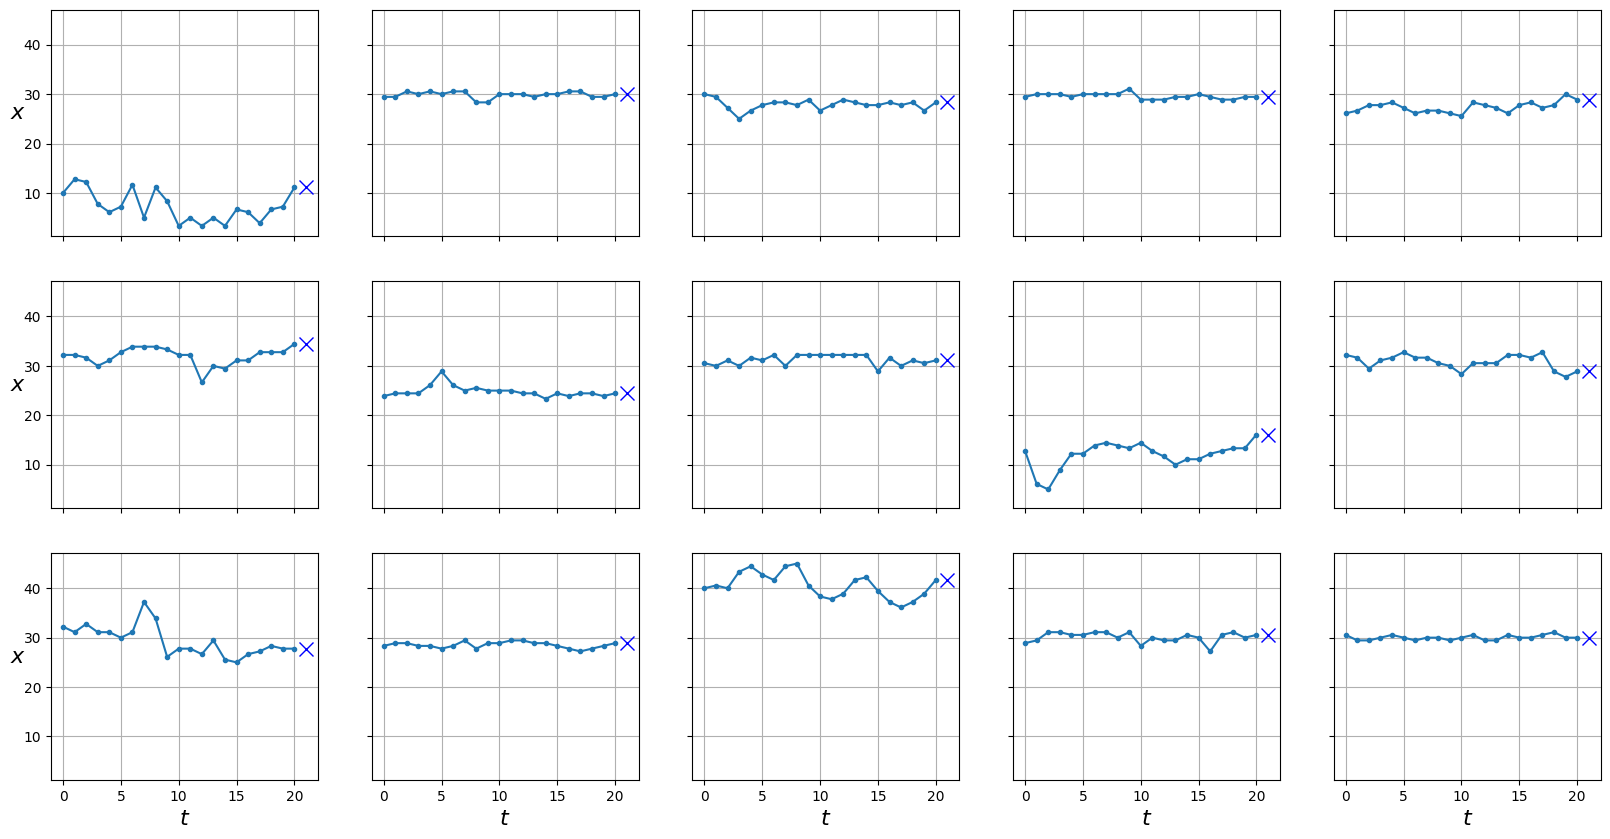

In [94]:
plot_series(X_test, y_test)


In [95]:
import torch 
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y=None, train=True):
        self.train = train
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.train:
            return torch.from_numpy(self.X[idx]), torch.from_numpy(self.y[idx])
        return torch.from_numpy(self.X[idx])


In [96]:
dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'valid': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'valid': DataLoader(dataset['valid'], batch_size=32, shuffle=False),
    'test': DataLoader(dataset['test'], batch_size=32, shuffle=False)
}

In [100]:
class RNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=64, num_layers=1, batch_first=True)
    self.fc = torch.nn.Linear(64, 1)

  def forward(self, x):
    x, h = self.rnn(x) 
    y = self.fc(x[:,-1])
    return y

rnn = RNN()

In [101]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        model.train()
        train_loss = []
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        model.eval()
        eval_loss = []
        with torch.no_grad():
            for batch in dataloader['valid']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
        bar.set_description(f"loss {np.mean(train_loss):.5f} val_loss {np.mean(eval_loss):.5f}")
        
def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds
            

In [102]:
fit(rnn, dataloader, epochs=50)


loss 0.00510 val_loss 0.02344: 100%|██████████| 50/50 [01:29<00:00,  1.79s/it]   


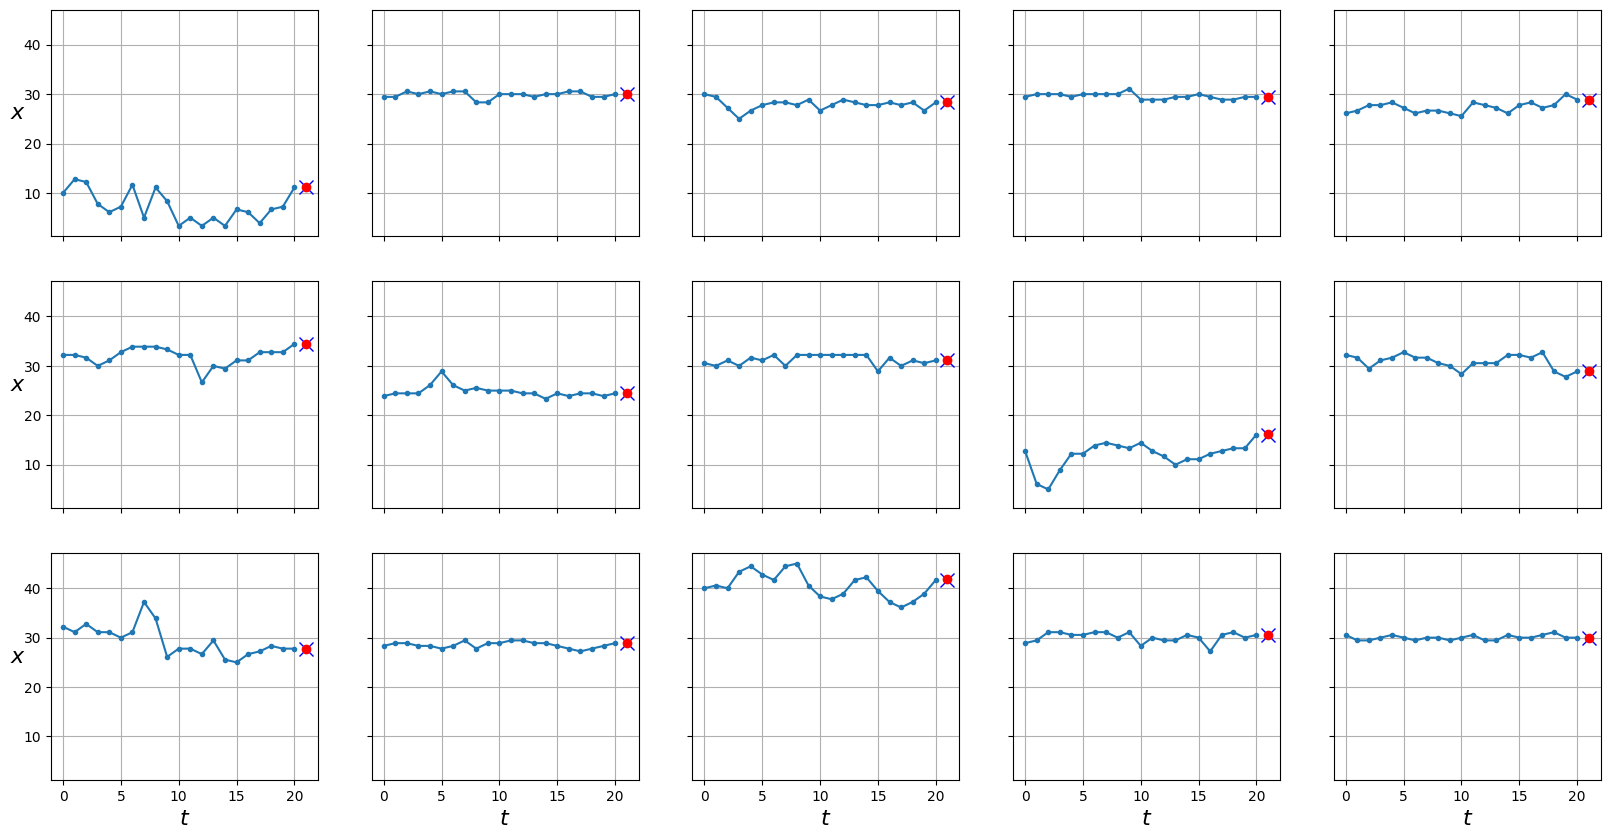

0.00623488612473011

In [104]:
from sklearn.metrics import mean_squared_error

y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())  # cpu() 张量值从gpu搬运到计算机内存
mean_squared_error(y_test, y_pred.cpu())


预测多个值

In [123]:
import numpy as np

# temp_values = sta_temps
# feature_size=3
# batch_size=4
# n_steps = 25
# label_size=5

def generate_time_series2(temp_values, batch_size, n_steps, feature_size=3, label_size=1):
    series = np.zeros((batch_size, n_steps, feature_size))
    sta_size = len(temp_values)
    sta_idx = np.random.randint(0, sta_size, batch_size)
    
    for i,idx in enumerate(sta_idx):
        temps = temp_values[idx]
        temp_size = len(temps)
        rnd_idx = np.random.randint(0, temp_size - n_steps)
        series[i] = np.array(temps[rnd_idx:rnd_idx+n_steps]).reshape(n_steps,-1)
    
    return series[:,:n_steps-label_size].astype(np.float32), series[:,-label_size:,0].astype(np.float32)


In [129]:
n_steps = 25
feature_size=1
label_size=5
max_temps = filted_maxtemp

X_train,y_train = generate_time_series2(max_temps, 7000, n_steps,feature_size, label_size)
X_valid,y_valid = generate_time_series2(max_temps, 2000, n_steps,feature_size, label_size)
X_test,y_test = generate_time_series2(max_temps, 1000, n_steps,feature_size, label_size)
X_train.shape, y_train.shape

((7000, 20, 1), (7000, 5))

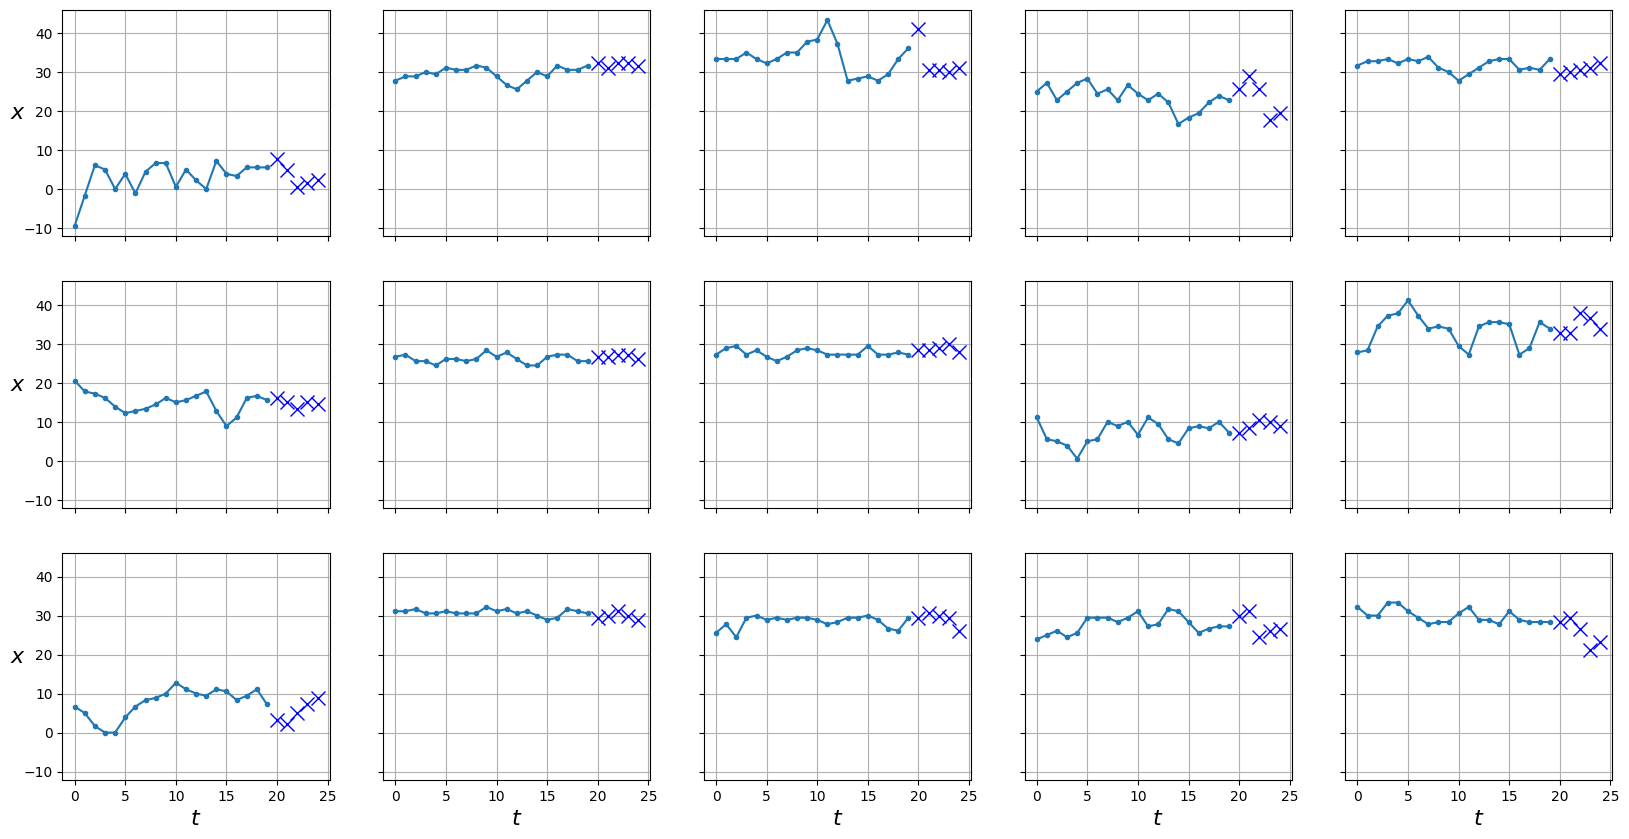

In [130]:
plot_series(X_test, y_test)

In [141]:
dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'valid': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'valid': DataLoader(dataset['valid'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

In [142]:
class DeepRNN(torch.nn.Module):
  def __init__(self, n_out=5):
    super().__init__()
    self.rnn = torch.nn.LSTM(input_size=1, hidden_size=128, num_layers=1, batch_first=True)
    self.fc = torch.nn.Linear(128, n_out)

  def forward(self, x):
    x, h = self.rnn(x) 
    x = self.fc(x[:,-1])
    return x
rnn2 = DeepRNN()

In [143]:
fit(rnn2, dataloader, epochs=50)

loss 5.76484 val_loss 6.67507: 100%|██████████| 50/50 [01:19<00:00,  1.60s/it]   


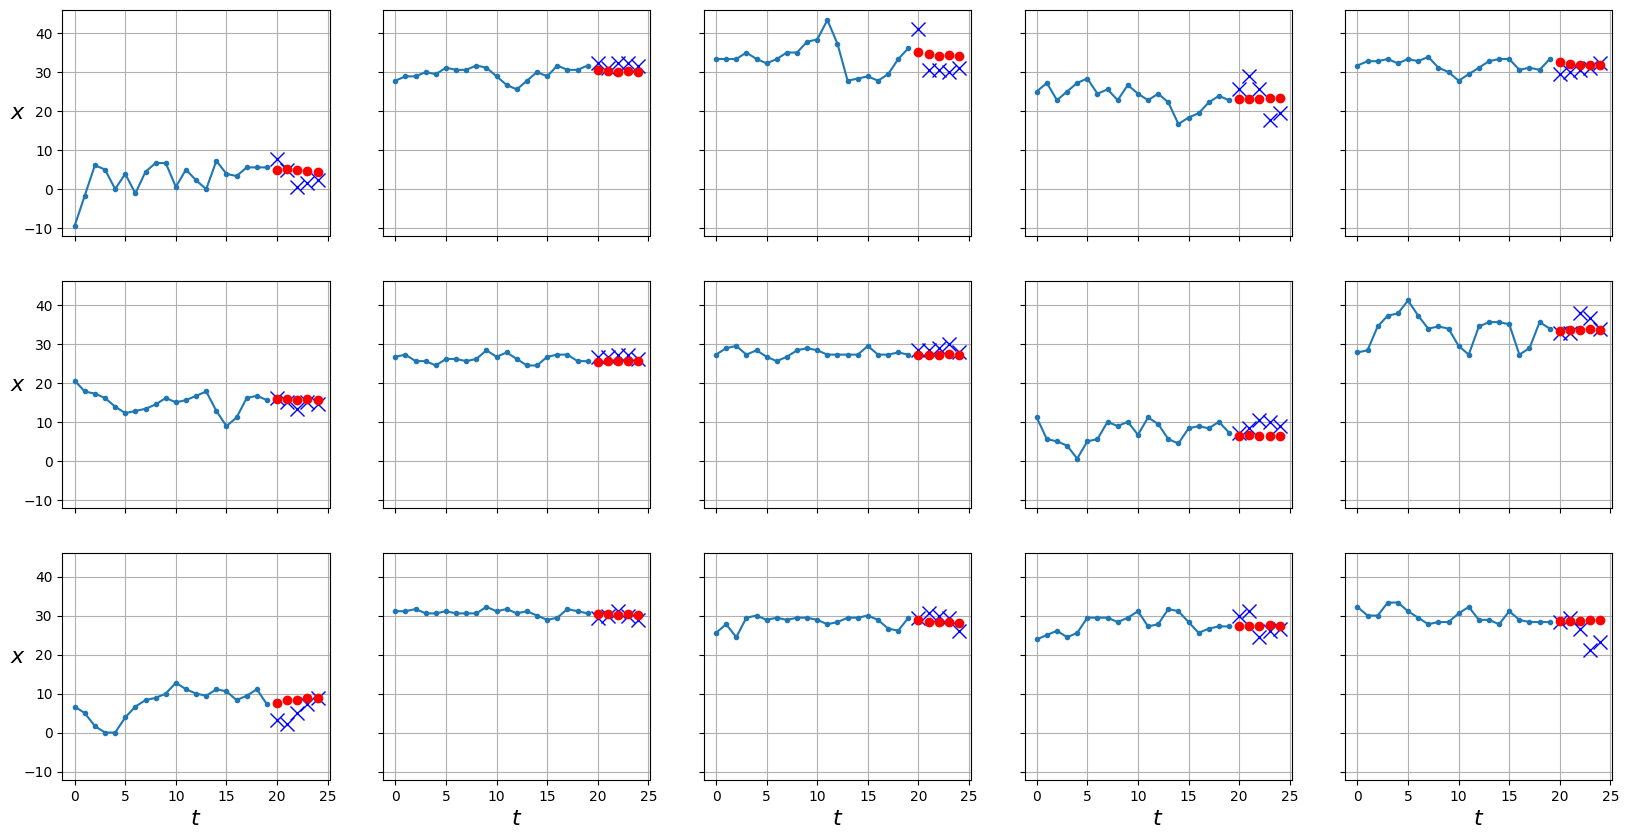

6.716926574707031

In [144]:
y_pred = predict(rnn2, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(y_test, y_pred.cpu())

In [ ]:
class DeepRNN(torch.nn.Module):
  def __init__(self,n_out=5):
    super().__init__()
    self.rnn = torch.nn.LSTM(input_size=1, hidden_size=64, num_layers=2, batch_first=True)
    self.pool = torch.nn.AvgPool1d(20)
    self.fc = torch.nn.Linear(64, n_out)

  def forward(self, x):
    x, h = self.rnn(x)
    x = x.permute(0,2,1)
    x = self.pool(x)
    x = x.squeeze(-1)
    y = self.fc(x)
    return y

rnn3 = DeepRNN()

In [ ]:
inp = torch.randn(64,20,1)
r = rnn3(inp)
r.shape

torch.Size([64, 5])

In [ ]:
fit(rnn3, dataloader, epochs=50)

loss 5.89044 val_loss 7.00986: 100%|██████████| 50/50 [01:32<00:00,  1.84s/it]   


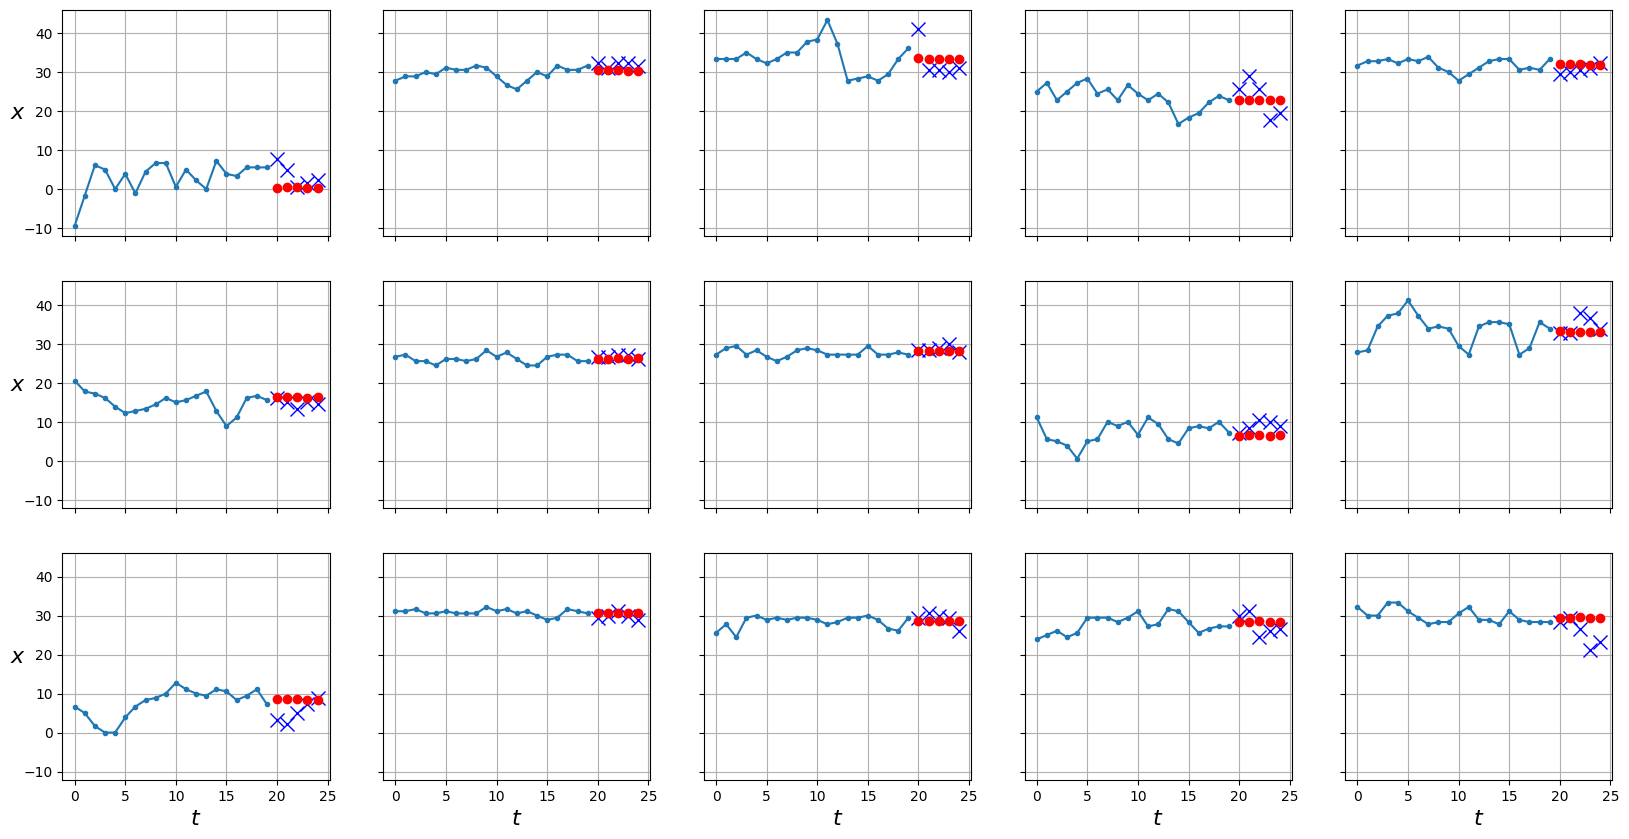

6.9277663230896

In [ ]:
y_pred = predict(rnn3, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(y_test, y_pred.cpu())